In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# mount gdrive 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4'

In [0]:
# DATAPREPARATION

def load():
	#Define the transformations for both Test & Train, we may use Data Augmentation, hence better to keep 2 functions for test & train

	# Transformation for Training
	train_transform = transforms.Compose(
    	[transforms.ToTensor(),
     	transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

	# Transformation for Test
	test_transform = transforms.Compose(
    	[transforms.ToTensor(),
     	transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

	#Get the Train and Test Set
	trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
	testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()
	print("CUDA Available?", cuda)

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

	classes = ('plane', 'car', 'bird', 'cat',
    	       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

	return classes, trainloader, testloader
 

In [0]:
# DISPLAY

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def show_random_images(dataset, classes):

	# get some random training images
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list]))
	# print labels
	print(' '.join('%5s' % classes[labels[j]] for j in img_list))


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) # output_size = 32, receptive field: 3   

        # Convolution Block 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # output_size = 32, , receptive field: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        ) # output_size = 32, receptive field: 7

        # Transition Block 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32, receptive field: 7

        # Max Pool 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16, receptive field: 8

        # Convolution Block 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # output_size = 16, receptive field: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        ) # output_size = 16, receptive field: 16

        # Transition Block 2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16, receptive field: 16

        # Max Pool 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8, receptive field: 18

        # Convolution Block 3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # output_size = 8, receptive field: 26

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        ) # output_size = 8, receptive field: 34

        # Transition Block 3
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8, receptive field: 34

        # Max Pool 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 4, receptive field: 38

        # Convolution Block 4
        # Depthwise Separable Convolution
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, groups=32, bias=False),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # output_size = 4, receptive field: 54

        #Dilated Convolution
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # output_size = 4, receptive field: 


         # Output Block 
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, receptive field: 

        self.convblock13 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 

    def forward(self, x):
        
        # Input Block
        x = self.convblock1(x)
        
        # Convolution Block 1
        x = self.convblock2(x)
        x = self.convblock3(x)
        
        # Transition Block 1
        x = self.convblock4(x)
        x = self.pool1(x)
        
        # Convolution Block 2
        x = self.convblock5(x)
        x = self.convblock6(x)
        
        # Transition Block 2
        x = self.convblock7(x)
        x = self.pool2(x)
        
        # Convolution Block 3
        x = self.convblock8(x)
        x = self.convblock9(x)
        
        # Transition Block 3
        x = self.convblock10(x)
        x = self.pool3(x)
        
        # Convolution Block 3
        x = self.convblock11(x)
        x = self.convblock12(x)
        
        # Output Block 3
        x = self.gap(x) 
        x = self.convblock13(x)       

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
# TRAINING AND TESTING LOOPS

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train_model(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test_model(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def show_predicted_actual(model, device, dataset, classes):
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# print images
	imshow(torchvision.utils.make_grid(images[img_list]))
	print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	images = images.to(device)
	outputs = model(images)

	_, predicted = torch.max(outputs, 1)
	print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in img_list))


def evaluate_accuracy(model, device, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [9]:
classes, trainloader, testloader = load()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat   cat


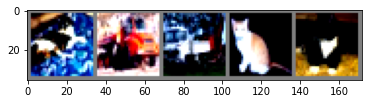

In [10]:
show_random_images(trainloader, classes)

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 32, 32]          73,728
              ReLU-8          [-1, 128, 32, 32]               0
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10           [-1, 32, 32, 32]           4,096
        MaxPool2d-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,432
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_model(model, device, trainloader, optimizer, criterion, epoch)
    test_model(model, device, criterion, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.890029788017273 Batch_id=390 Accuracy=53.14: 100%|██████████| 391/391 [00:13<00:00, 28.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 6208/10000 (62.08%)

EPOCH: 2


Loss=0.9533961415290833 Batch_id=390 Accuracy=70.43: 100%|██████████| 391/391 [00:13<00:00, 28.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6984/10000 (69.84%)

EPOCH: 3


Loss=0.6349443197250366 Batch_id=390 Accuracy=76.76: 100%|██████████| 391/391 [00:13<00:00, 28.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7447/10000 (74.47%)

EPOCH: 4


Loss=0.6432932615280151 Batch_id=390 Accuracy=80.42: 100%|██████████| 391/391 [00:13<00:00, 28.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7588/10000 (75.88%)

EPOCH: 5


Loss=0.4274052679538727 Batch_id=390 Accuracy=82.94: 100%|██████████| 391/391 [00:13<00:00, 28.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8026/10000 (80.26%)

EPOCH: 6


Loss=0.5160706043243408 Batch_id=390 Accuracy=84.88: 100%|██████████| 391/391 [00:13<00:00, 28.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7940/10000 (79.40%)

EPOCH: 7


Loss=0.34945914149284363 Batch_id=390 Accuracy=87.09: 100%|██████████| 391/391 [00:13<00:00, 28.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8065/10000 (80.65%)

EPOCH: 8


Loss=0.473052442073822 Batch_id=390 Accuracy=88.42: 100%|██████████| 391/391 [00:13<00:00, 29.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7983/10000 (79.83%)

EPOCH: 9


Loss=0.3770621120929718 Batch_id=390 Accuracy=89.44: 100%|██████████| 391/391 [00:13<00:00, 29.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7974/10000 (79.74%)

EPOCH: 10


Loss=0.34946802258491516 Batch_id=390 Accuracy=90.74: 100%|██████████| 391/391 [00:13<00:00, 29.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8055/10000 (80.55%)

EPOCH: 11


Loss=0.25722557306289673 Batch_id=390 Accuracy=91.76: 100%|██████████| 391/391 [00:13<00:00, 29.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8026/10000 (80.26%)

EPOCH: 12


Loss=0.20955350995063782 Batch_id=390 Accuracy=92.96: 100%|██████████| 391/391 [00:13<00:00, 29.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8116/10000 (81.16%)

EPOCH: 13


Loss=0.16857875883579254 Batch_id=390 Accuracy=93.69: 100%|██████████| 391/391 [00:13<00:00, 28.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8057/10000 (80.57%)

EPOCH: 14


Loss=0.2282140552997589 Batch_id=390 Accuracy=94.66: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8154/10000 (81.54%)

EPOCH: 15


Loss=0.11899175494909286 Batch_id=390 Accuracy=94.90: 100%|██████████| 391/391 [00:13<00:00, 28.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8119/10000 (81.19%)

EPOCH: 16


Loss=0.12683603167533875 Batch_id=390 Accuracy=95.74: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8114/10000 (81.14%)

EPOCH: 17


Loss=0.13846249878406525 Batch_id=390 Accuracy=96.12: 100%|██████████| 391/391 [00:13<00:00, 28.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8167/10000 (81.67%)

EPOCH: 18


Loss=0.055199213325977325 Batch_id=390 Accuracy=96.80: 100%|██████████| 391/391 [00:14<00:00, 27.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8171/10000 (81.71%)

EPOCH: 19


Loss=0.13052895665168762 Batch_id=390 Accuracy=97.06: 100%|██████████| 391/391 [00:13<00:00, 28.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8166/10000 (81.66%)

EPOCH: 20


Loss=0.13632270693778992 Batch_id=390 Accuracy=97.41: 100%|██████████| 391/391 [00:13<00:00, 28.57it/s]



Test set: Average loss: 0.0060, Accuracy: 8199/10000 (81.99%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    car  ship  bird horse  ship
Predicted:    car  ship  bird horse  ship


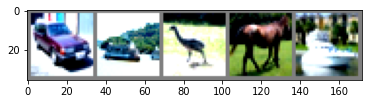

In [16]:
show_predicted_actual(model, device, testloader, classes)

In [17]:
evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 81 %


In [18]:
evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 83 %
Accuracy of   car : 100 %
Accuracy of  bird : 78 %
Accuracy of   cat : 68 %
Accuracy of  deer : 80 %
Accuracy of   dog : 83 %
Accuracy of  frog : 86 %
Accuracy of horse : 78 %
Accuracy of  ship : 96 %
Accuracy of truck : 87 %
